# Initialize   

In [1]:
import numpy as np
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# SEIR Class

In [28]:
class SEIRModel:
    def __init__(self, population, beta, sigma, gamma):
        self.population = population
        self.beta = beta
        self.sigma = sigma
        self.gamma = gamma
        self.s = population 
        self.e = 10
        self.i = 0
        self.r = 0

    def step(self):
        new_infections = self.beta * self.s * self.i / self.population
        new_exposed = new_infections
        new_recovered = self.gamma * self.i
        self.s -= new_infections
        self.e += new_exposed
        self.i += new_infections - new_recovered
        self.r += new_recovered

    def get_infected(self):
        return int(self.i)

    def __call__(self, y, t, N, beta, sigma, gamma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S * I / N - sigma * E
        dIdt = sigma * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

# Load data

In [29]:
def load_df(data_name: str) -> pd.DataFrame:
  path = f"nb_datasets/{data_name}"

  df:pd.DataFrame = pd.read_csv(path)

  # ensure sort by date
  df['date'] = pd.to_datetime(df['date'])
  df_sorted: pd.DataFrame = df.sort_values(by='date')
  
  return df_sorted

# Split data

In [30]:
def load_observed(df: pd.DataFrame, brgy_name: str) -> pd.DataFrame:
  
  df_sorted: pd.DataFrame = df[df['barangay_Res'] == brgy_name]

  # keep relevant cols
  keep_cols = ["date", "count_Exposed", "count_Infectious", "count_Recovered"]
  main_df: pd.DataFrame = df_sorted[df_sorted.columns.intersection(keep_cols)]

  # Observed data (e.g., daily infections)
  # observed_data = main_df['count_Infectious'].to_numpy()

  # total_cases = main_df['count_Infectious'].sum()
  
  return main_df


# Sim Anneal Code

In [54]:
# Simulate SEIR model
def simulate_seir(beta, sigma, gamma, y0, t):
    N = 32841 # From searching (how to get from data?)
    seir_model = SEIRModel(N, beta, sigma, gamma)
    # Solve ODEs for SEIR
    result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma))
    S, E, I, R = result.T
    return I  # Return only the infectious compartment for fitting


# Objective function
def objective_function(params, observed_data, initial_conditions, time_points):
    beta, sigma, gamma = params

    # Simulate the SEIR model with given parameters
    predicted_data = simulate_seir(beta, sigma, gamma, initial_conditions, time_points)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((predicted_data - observed_data)**2)
    return mse


# Simulated Annealing for SEIR parameter tuning
def simulated_annealing_seir(observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter):
    # Initial parameter guesses
    current_params = [0.3, 0.1, 0.1]  # Initial guesses for beta, sigma, gamma
    current_cost = objective_function(current_params, observed_data, initial_conditions, time_points)
    best_params = current_params
    best_cost = current_cost

    for i in range(max_iter):
        # Generate new candidate parameters
        new_params = [param + random.uniform(-0.025, 0.025) for param in current_params]
        new_params = np.clip(new_params, 0, 1)  # Keep parameters in a valid range (0 to 1)

        # Evaluate the new candidate solution
        new_cost = objective_function(new_params, observed_data, initial_conditions, time_points)

        # Decide whether to accept the new solution
        if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temp):
            current_params = new_params
            current_cost = new_cost

            # Update the best solution found so far
            if new_cost < best_cost:
                best_params = new_params
                best_cost = new_cost

        # Cool down the temperature
        temp *= cooling_rate

    return best_params, best_cost

# Run Sim Anneal

C:\Users\pc-user\AppData\Local\Temp\ipykernel_13748\2167904581.py:40: RuntimeWarning: overflow encountered in scalar divide
  if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temp):


Best parameters: Beta=0.001, Sigma=0.286, Gamma=0.000
Best cost (MSE): 116.497


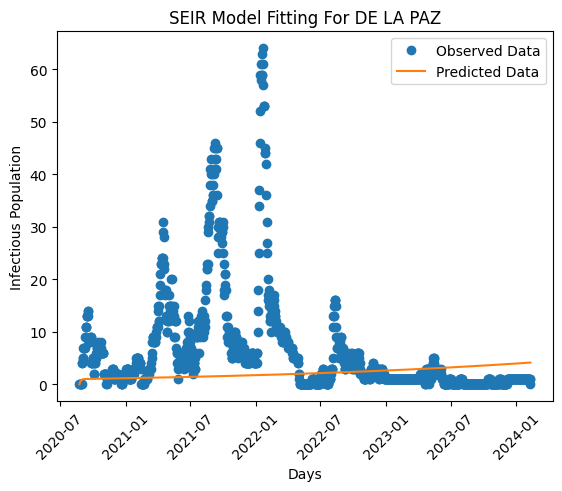

In [60]:
brgy_name = "DE LA PAZ"
main_df: pd.DataFrame = load_df("CITY_OF_BIÑAN_processed.csv")
df_observed_data: pd.DataFrame = load_observed(main_df, brgy_name) # Change to check for other Brgys.
i_observed_data = df_observed_data['count_Infectious'].to_numpy()

# Initial parameters
N = 33235  # Population from google search (how to get from data?)
I0 = df_observed_data['count_Infectious'].iloc[0] # Initial infected from data
E0 = df_observed_data['count_Exposed'].iloc[0] # Initial exposed cases
R0 = df_observed_data['count_Recovered'].iloc[0] # Initial recovered
S0 = N - I0 - E0 - R0  # Susceptible

initial_conditions: tuple = [S0, E0, I0, R0]

# Time points (days)
time_points = np.arange(len(i_observed_data)) # odeint expects an array (vector) of integers.

# Simulated Annealing parameters
temp = 10000           # Initial temperature
cooling_rate = 0.90   # Cooling rate
max_iter = 10000       # Number of iterations


# Time points (days)
time_points = np.arange(len(i_observed_data))

# Simulated Annealing parameters
temp = 25000           # Initial temperature
cooling_rate = 0.90   # Cooling rate
max_iter = 25000       # Number of iterations

# Run the Simulated Annealing algorithm
best_params, best_cost = simulated_annealing_seir(i_observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter)
o_beta, o_sigma, o_gamma = best_params

# Display results
print(f"Best parameters: Beta={o_beta:.3f}, Sigma={o_sigma:.3f}, Gamma={o_gamma:.3f}")
print(f"Best cost (MSE): {best_cost:.3f}")

# Visualize the results
predicted_data = simulate_seir(*best_params, initial_conditions, time_points)


plot_actual = pd.DataFrame({
    'date': df_observed_data['date'],
    'count_Infectious': i_observed_data
})
plot_prediction = pd.DataFrame({
    'date': df_observed_data['date'],
    'count_Infectious': predicted_data
})

plt.plot(plot_actual['date'], plot_actual['count_Infectious'], 'o', label='Observed Data')
plt.plot(plot_prediction['date'], plot_prediction['count_Infectious'], '-', label='Predicted Data')
plt.xlabel('Days')
plt.ylabel('Infectious Population')
plt.legend()
plt.xticks(rotation=45)
plt.title(f'SEIR Model Fitting For {brgy_name}')
plt.show()